# Practica computacional 1: Analisis cuantitativo de comportamiento

## Conociendo los datos

![] (https://journals.plos.org/ploscompbiol/article/figure/image?size=large&id=10.1371/journal.pcbi.1012753.g001)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/My\ Drive/behavior_fly
!pip install statannot
!pip install npstructures
!pip install kaleido

/content/drive/My Drive/behavior_fly
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 3.7 MB/s eta 0:00:00


In [2]:
!pip install kaleido

In [3]:
!pip install seaborn==0.12.2

import seaborn as sns
print("Seaborn version:", sns.__version__)

Seaborn version: 0.12.2


In [4]:
import os
import kaleido
import pathlib
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import figure
mpl.rcParams['figure.dpi']= 500 #set quality of graphs generated #increased number for increased quality
import math
import statistics as statis
import seaborn as sns
import sys
import plotly.express as px
from statannot import add_stat_annotation
from scipy import stats
from scipy import signal
import math
from npstructures import RaggedArray
from tqdm import tqdm
from numba import jit
from matplotlib.gridspec import GridSpec
# trajectorytools needs to be installed. To install,
# pip install trajectorytools or follow the instructions at
# http://www.github.com/fjhheras/trajectorytools
'''
import trajectorytools as tt
import trajectorytools.plot as ttplot
import trajectorytools.socialcontext as ttsocial
from trajectorytools.constants import dir_of_data
'''
import pandas as pd
import plotly.express as px
import plotly.io as pio

# ignore some future warnings that are annoying
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# install
# !{sys.executable} -m pip install tqdm
# !{sys.executable} -m pip install npstructures
#!{sys.executable} -m pip uninstall ploty pip install plotly==5.3.1 import plotly import kaleido

/usr/local/lib/python3.11/dist-packages/kaleido/__init__.py:14: UserWarning: 


This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.

  from .kaleido import Kaleido


# Load datasets and obtain stats

In [5]:
class animal_behavior_stats:
    def __init__(self, path, trial_length=600, label="experiment"):
        self.path          = path
        self.label         = label          # purely for plot titles
        self.trial_length  = trial_length
        self.time          = np.linspace(0, trial_length, trial_length)

        # containers --------------------------------------------------- #
        self.x, self.y     = [], []
        self.sp, self.an   = [], []
        self.ac            = []
        self.spline_x      = pd.DataFrame()
        self.spline_sp     = pd.DataFrame()
        self.weird_fish    = 0

        self._load_data()
        self.num_indiv = len(self.x)
        print(f"Loaded {self.num_indiv} fish")

    # ------------------------------------------------------------------ #
    def _load_data(self):
        list_files = [os.path.join(r, f)
                      for r, _, files in os.walk(self.path)
                      for f in files if f.endswith(".npz")]

        if not list_files:
            raise FileNotFoundError("No .npz files found in supplied path.")

        # ----------- ingest each fish --------------------------------- #
        for file_path in tqdm(list_files, desc="Loading fish"):
            data  = np.load(file_path)
            mask  = ~data["missing"].astype(bool)

            x_pos = data["X#wcentroid"][mask]
            y_pos = data["Y#wcentroid"][mask]
            speed = data["SPEED"][mask]
            angle = data["ANGLE"][mask]
            acc   = data["ACCELERATION#wcentroid"][mask]

            # clean
            speed[(speed == np.inf) | (speed <= 0)] = 0
            angle[angle == np.inf] = 0
            acc[acc == np.inf]     = 0

            # -------- normalise coords (no left/right flip) ------------ #
            x_norm = (x_pos - np.nanmin(x_pos))
            x_norm = x_norm / ((np.nanmax(x_pos) - np.nanmin(x_pos)) / 2) - 1
            y_norm = (y_pos - np.nanmin(y_pos)) / (np.nanmax(y_pos) - np.nanmin(y_pos))

            # stash raw
            self.x .append(x_norm)
            self.y .append(y_norm)
            self.sp.append(speed)
            self.an.append(angle)
            self.ac.append(acc)

            # spline (skip very short tracks)
            if len(x_norm) < 10:
                self.weird_fish += 1
                continue
            self._add_splines(x_norm, speed)

        # convert to RaggedArray once
        self.x  = RaggedArray(self.x)
        self.y  = RaggedArray(self.y)
        self.sp = RaggedArray(self.sp)
        self.an = RaggedArray(self.an)
        self.ac = RaggedArray(self.ac)

    # ---------------- helpers ----------------------------------------- #
    def _add_splines(self, x_sig, sp_sig):
        from scipy.interpolate import CubicSpline
        ts   = np.linspace(0, self.trial_length, len(x_sig))
        cx   = CubicSpline(ts, x_sig)(self.time)
        cs   = CubicSpline(ts, sp_sig)(self.time)
        cs[cs < 0] = 0                           # speed only
        self.spline_x  = pd.concat([self.spline_x,  pd.Series(cx)],  axis=1)
        self.spline_sp = pd.concat([self.spline_sp, pd.Series(cs)],  axis=1)

In [6]:
def plot_x_pos_single(fish_obj,
                      title        = "Average X-position",
                      color        = "blue",
                      trial_length = None,
                      ylims        = (-1,1)):
    """
    Plot the normalised X-position of the single animal contained in `fish_obj`.

    Parameters
    ----------
    fish_obj : animal_behavior_stats
        Object returned by your loader (one fish inside).
    title : str
        Plot title.
    color : str
        Matplotlib colour spec.
    trial_length : int | None
        X-axis upper limit; defaults to fish_obj.trial_length.
    ylims : tuple(float, float)
        Y-axis limits.
    """

    # single column → numpy vector
    traj = fish_obj.spline_x.iloc[:, 0].values

    # --- plot --------------------------------------------------------- #
    plt.figure(figsize=(10, 7))
    plt.plot(fish_obj.time, traj, color=color, linewidth=4)

    ax = plt.gca()
    ax.set_ylim(*ylims)
    ax.set_xlim(0, trial_length)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.title(title, fontsize=20, fontweight='bold')
    plt.xlabel("Time (s)")
    plt.ylabel("X-Position (normalised)")
    plt.legend(["n = 1"], frameon=False)

    # reference line at centre
    plt.axhline(0, color='black', linestyle='--', linewidth=3)

    plt.show()

In [7]:
%cd /content/drive/My\ Drive/behavior_fly
!ls

/content/drive/My Drive/behavior_fly
20220418_cam4_flid46_trim-2_fish0.npz


In [75]:
control = animal_behavior_stats(path = r'/content/drive/My Drive/behavior_fly/',trial_length=105,label="test")

Loading fish: 100%|██████████| 1/1 [00:00<00:00, 37.65it/s]

Loaded 1 fish


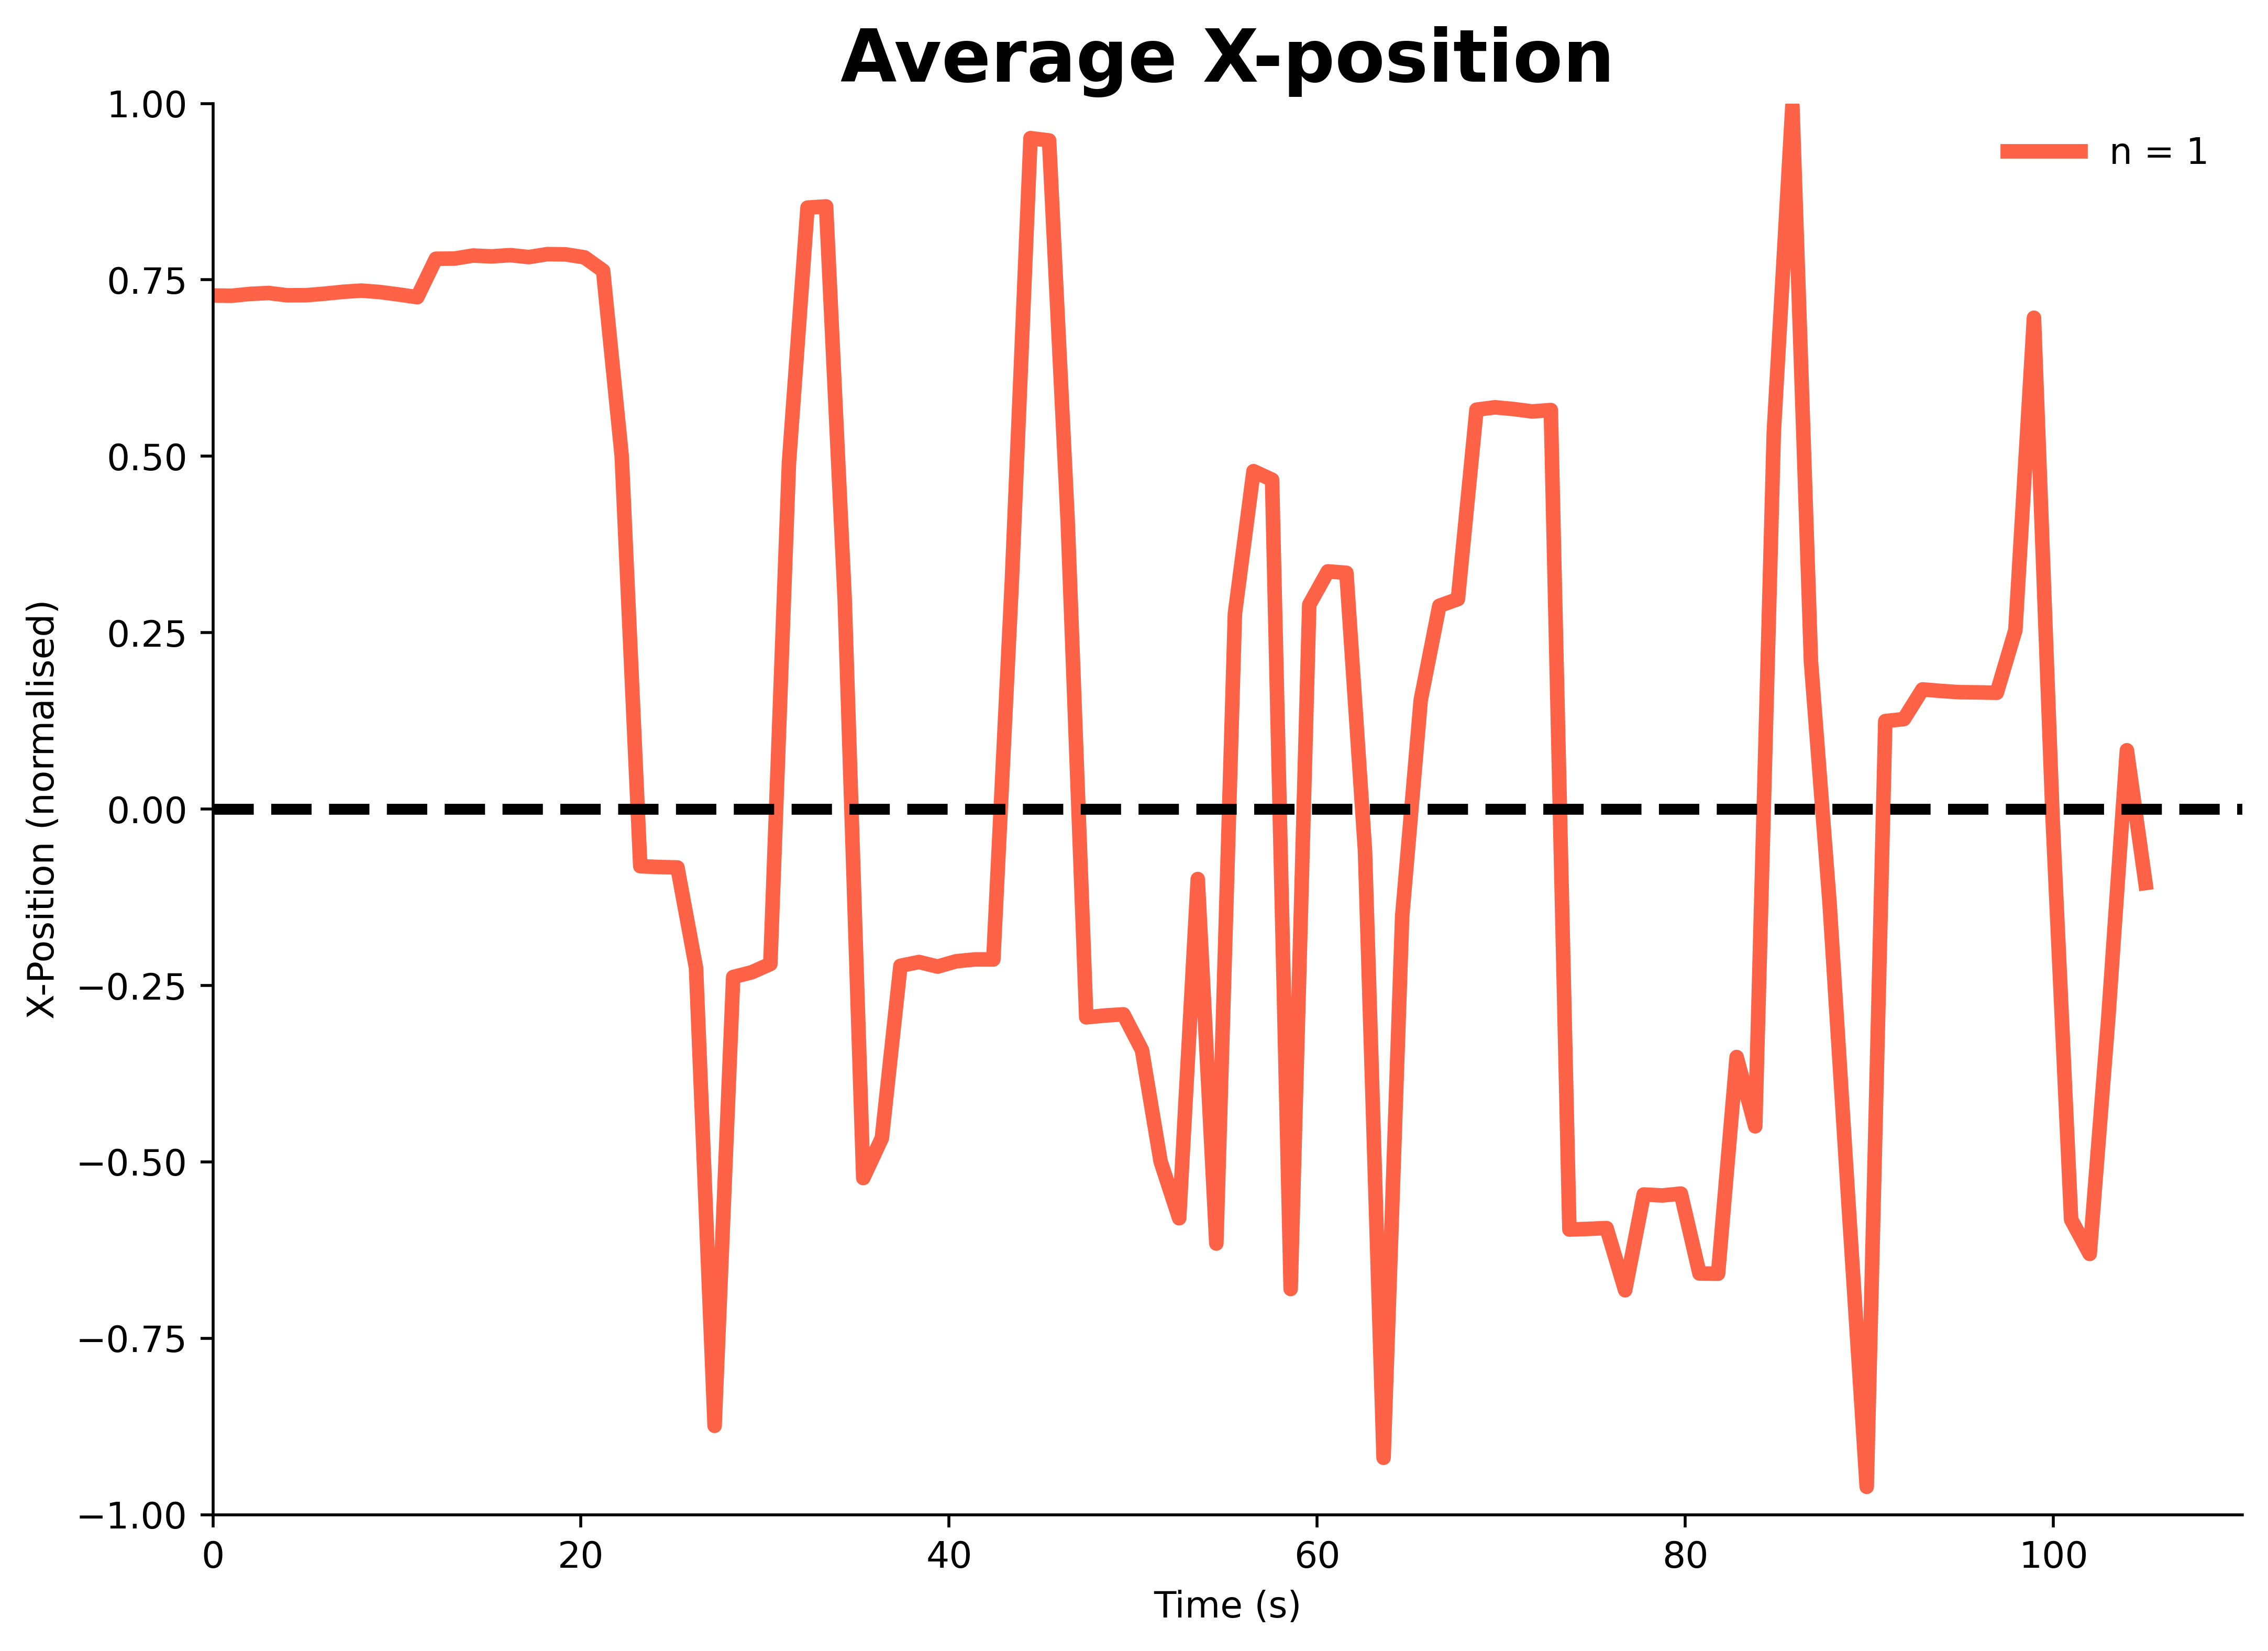

In [76]:
plot_x_pos_single(control, color="tomato")

In [77]:
def plot_area_heatmap_single(
        fish_obj,
        title       = "Area heat-map",
        nbinsx      = 20,
        nbinsy      = 20,
        color_range = (0, 4)):
    """
    Show (and optionally save) a 2-D occupancy heat-map for a single animal.
    """

    # grab the first (and only) animal
    x_vals = pd.Series(fish_obj.x[0, :])
    y_vals = pd.Series(fish_obj.y[0, :])
    n_pts  = len(x_vals)

    df = pd.DataFrame({"X-position": x_vals, "Y-position": y_vals})

    fig = px.density_heatmap(
        df,
        x="X-position",
        y="Y-position",
        nbinsx=nbinsx,
        nbinsy=nbinsy,
        marginal_x="histogram",
        marginal_y="histogram",
        histnorm="percent",
        range_color=color_range,
    )

    # layout tweaks
    fig.update_layout(
        title=dict(text=f"<b>{title}</b>", x=0.5, y=0.95, xanchor="center"),
        font=dict(size=24),
        margin=dict(t=70, b=40, l=40, r=40),
    )
    fig.update_xaxes(title_font=dict(size=25))
    fig.update_yaxes(title_font=dict(size=25))

    # show it
    #fig.show()

    return fig


In [78]:
plot_area_heatmap_single(control)

In [43]:
control.spline_sp

0
0        0.000000
1      124.171075
2      126.100851
3      105.624744
4      122.282680
...           ...
10495  123.435777
10496  113.211769
10497  109.268679
10498   99.410809
10499  133.849899

[10500 rows x 1 columns]

In [79]:
def plot_speed_single(
        fish_obj,
        title        = "Speed vs Time",
        color        = "blue",
        trial_length = None,
        ylims        = (0, 5),
        figsize      = (10, 5)):
    """
    Plot the spline-resampled speed (cm/s) for the single animal in `fish_obj`.

    Parameters
    ----------
    fish_obj      : animal_behavior_stats
    title         : str      – plot title
    color         : str      – line colour
    trial_length  : int|None – x-axis upper limit; defaults to fish_obj.trial_length
    ylims         : tuple    – (ymin, ymax)
    figsize       : tuple    – passed to plt.figure
    """

    # fall back to default trial length
    trial_length = trial_length or fish_obj.trial_length

    # safety: expect exactly one column
    if fish_obj.spline_sp.shape[1] == 0:
        raise ValueError("fish_obj.spline_sp is empty – did spline building run?")

    speed = fish_obj.spline_sp.iloc[:, 0].values   # one column → 1-D array

    plt.figure(figsize=figsize)
    plt.plot(fish_obj.time, speed, color=color, linewidth=3)

    ax = plt.gca()
    ax.set_ylim(*ylims)
    ax.set_xlim(0, trial_length)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.title(title, fontsize=20, fontweight="bold")
    plt.xlabel("Time (s)")
    plt.ylabel("Speed (mm/s)")
    plt.legend(["n = 1"], frameon=False)

    # reference line at 0 cm/s for context
    plt.axhline(0, linestyle="--", color="black", linewidth=1)

    plt.show()

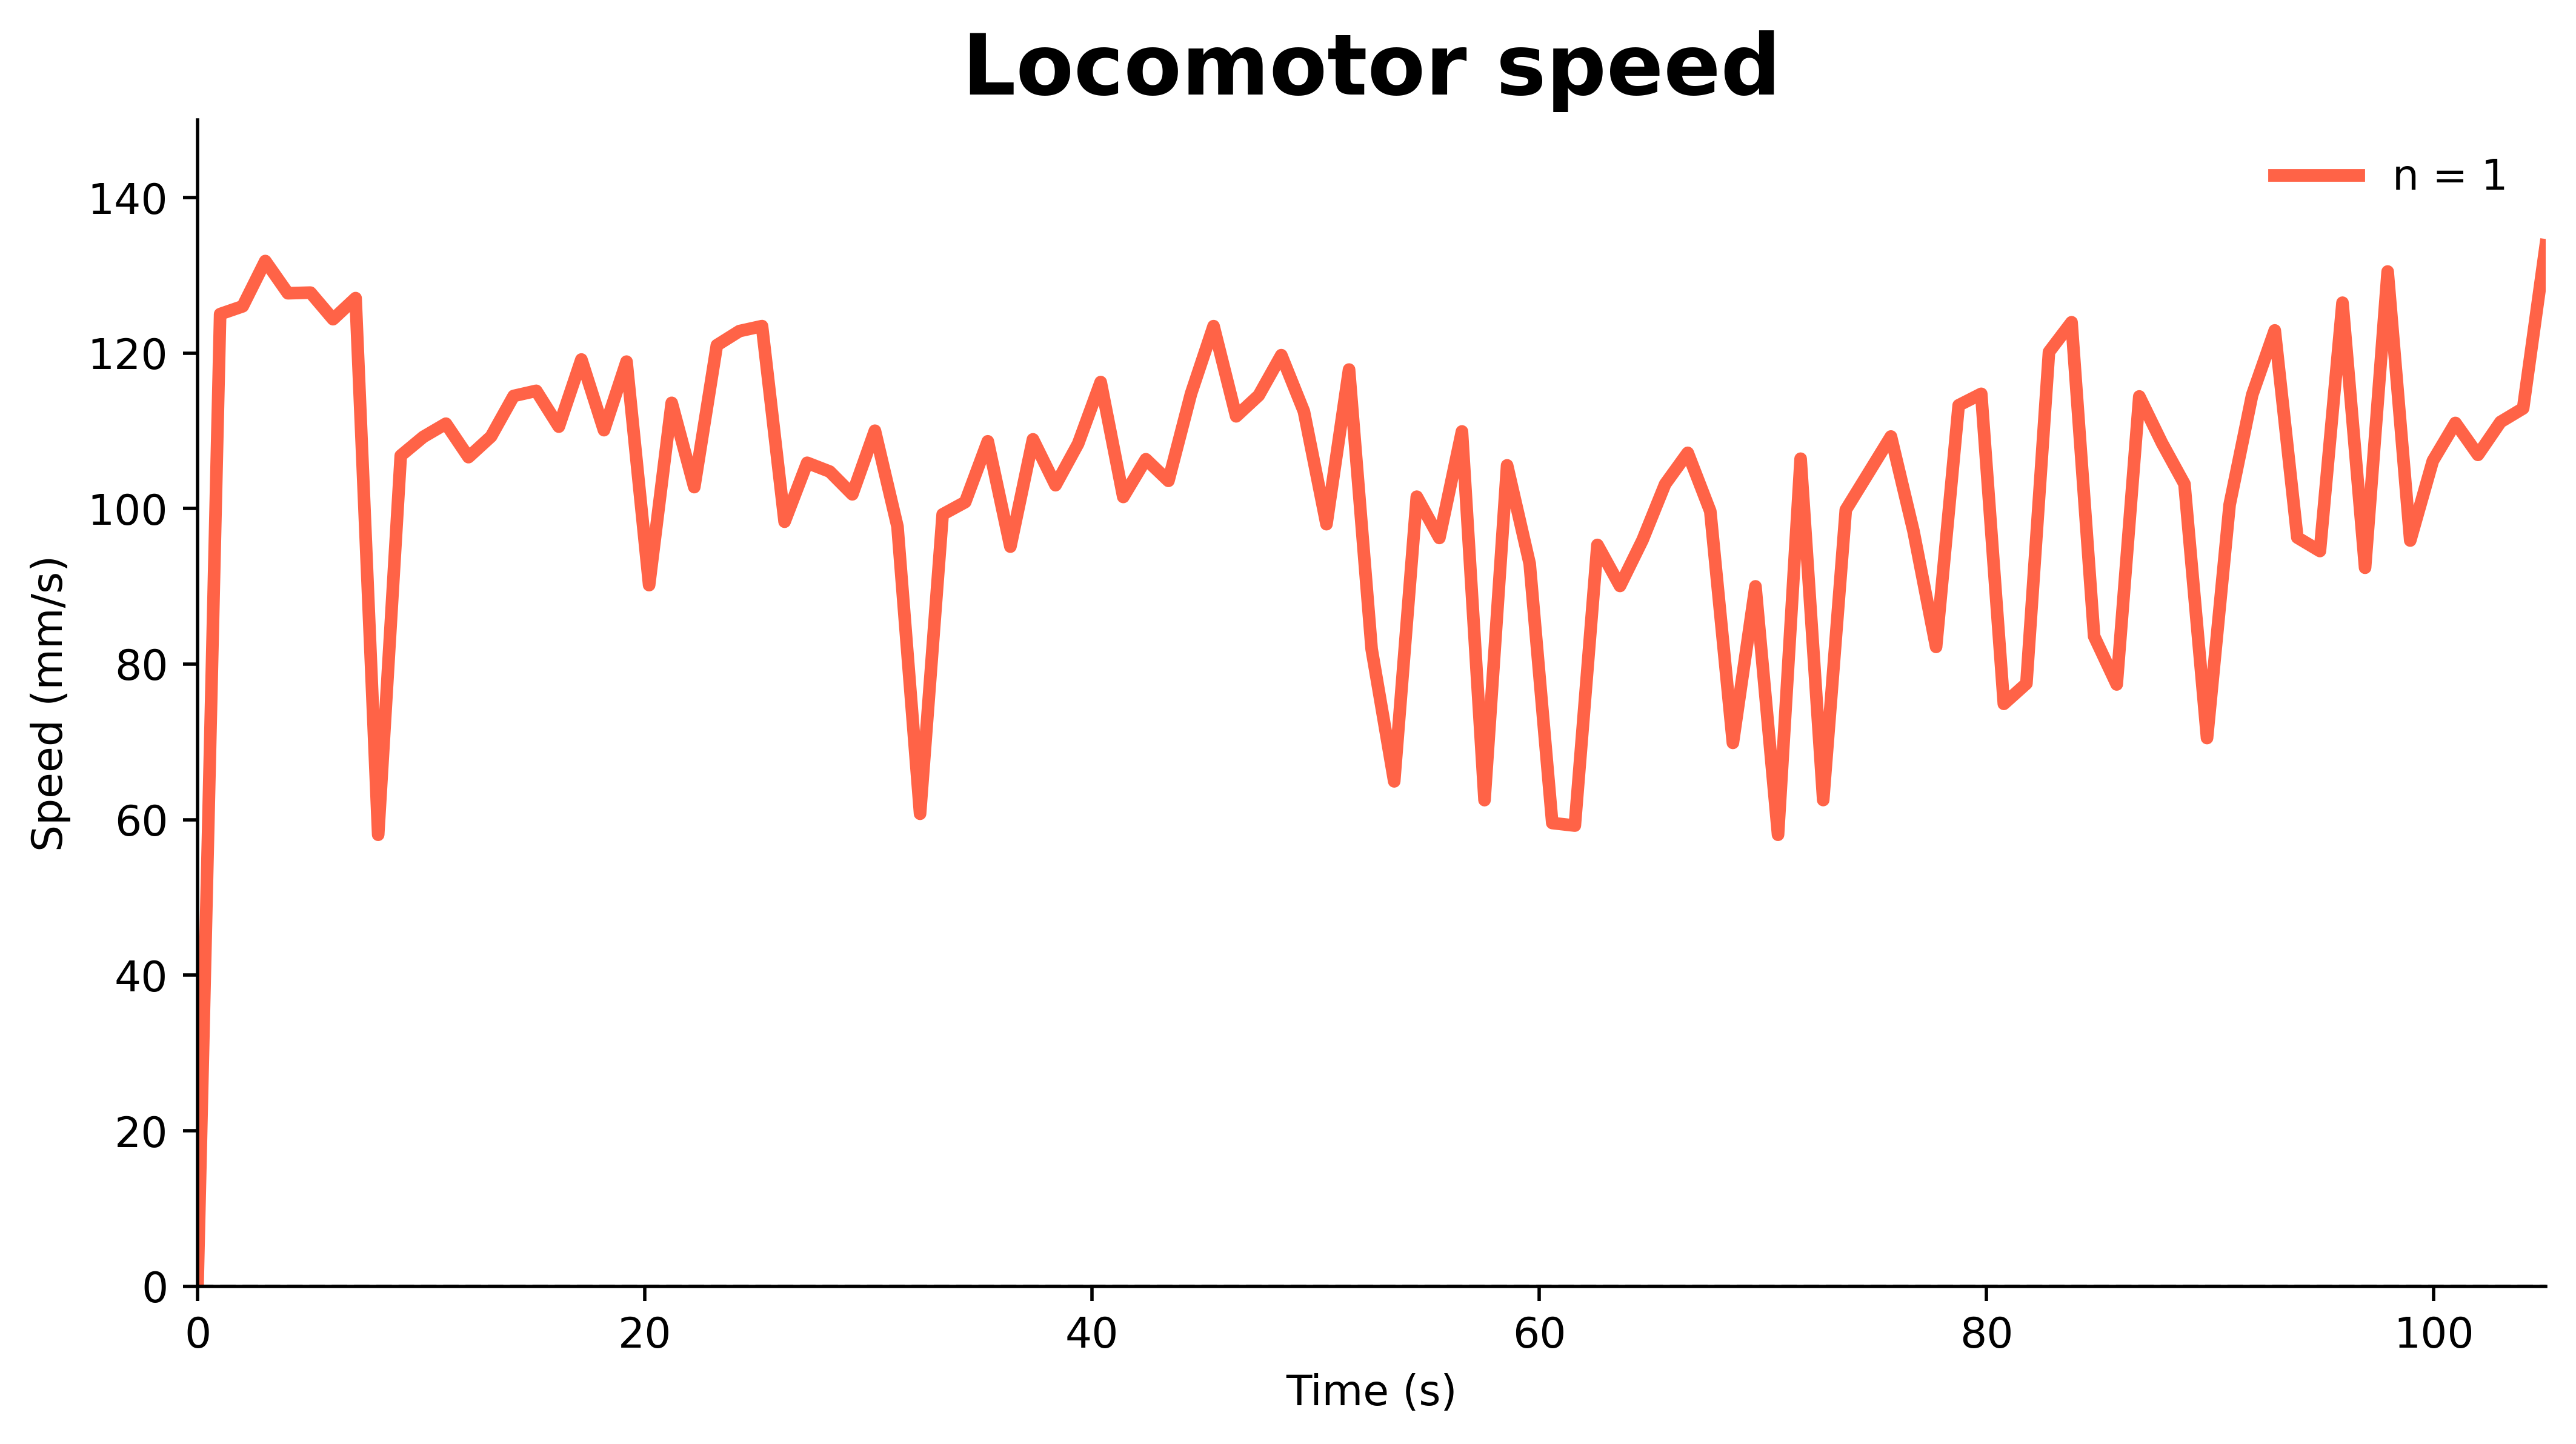

In [85]:
plot_speed_single(control,           # display only
                  title="Locomotor speed",
                  color="tomato",
                  ylims=(0, 150))

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

def plot_trajectory_time_heatmap(fish_obj,
                                 cmap         = "viridis",
                                 figsize      = (5, 7),
                                 title        = "Trajectory (colour = time)",
                                 scatter_tail = False):
    """
    Draw the X–Y path; colour fades from start (dark) → end (bright).
    """

    x, y = fish_obj.x[0], fish_obj.y[0]
    t    = fish_obj.time[: len(x)]         # guard in case traces differ by 1 step

    # build line segments between successive points
    points   = np.vstack([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    norm = Normalize(vmin=t.min(), vmax=t.max())
    lc   = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(t[:-1])
    lc.set_linewidth(2)

    fig, ax = plt.subplots(figsize=figsize)
    ax.add_collection(lc)
    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect("equal")
    ax.set_xlabel("X (normalised)")
    ax.set_ylabel("Y (normalised)")
    ax.set_title(title, fontweight="bold")

    plt.colorbar(lc, ax=ax, label="Time (s)")

    # optional scatter on top to emphasise tail/head
    if scatter_tail:
        ax.scatter(x[0],  y[0],  c="black", s=40, label="start")
        ax.scatter(x[-1], y[-1], c="white", edgecolor="black", s=40, label="end")
        ax.legend()

    plt.show()

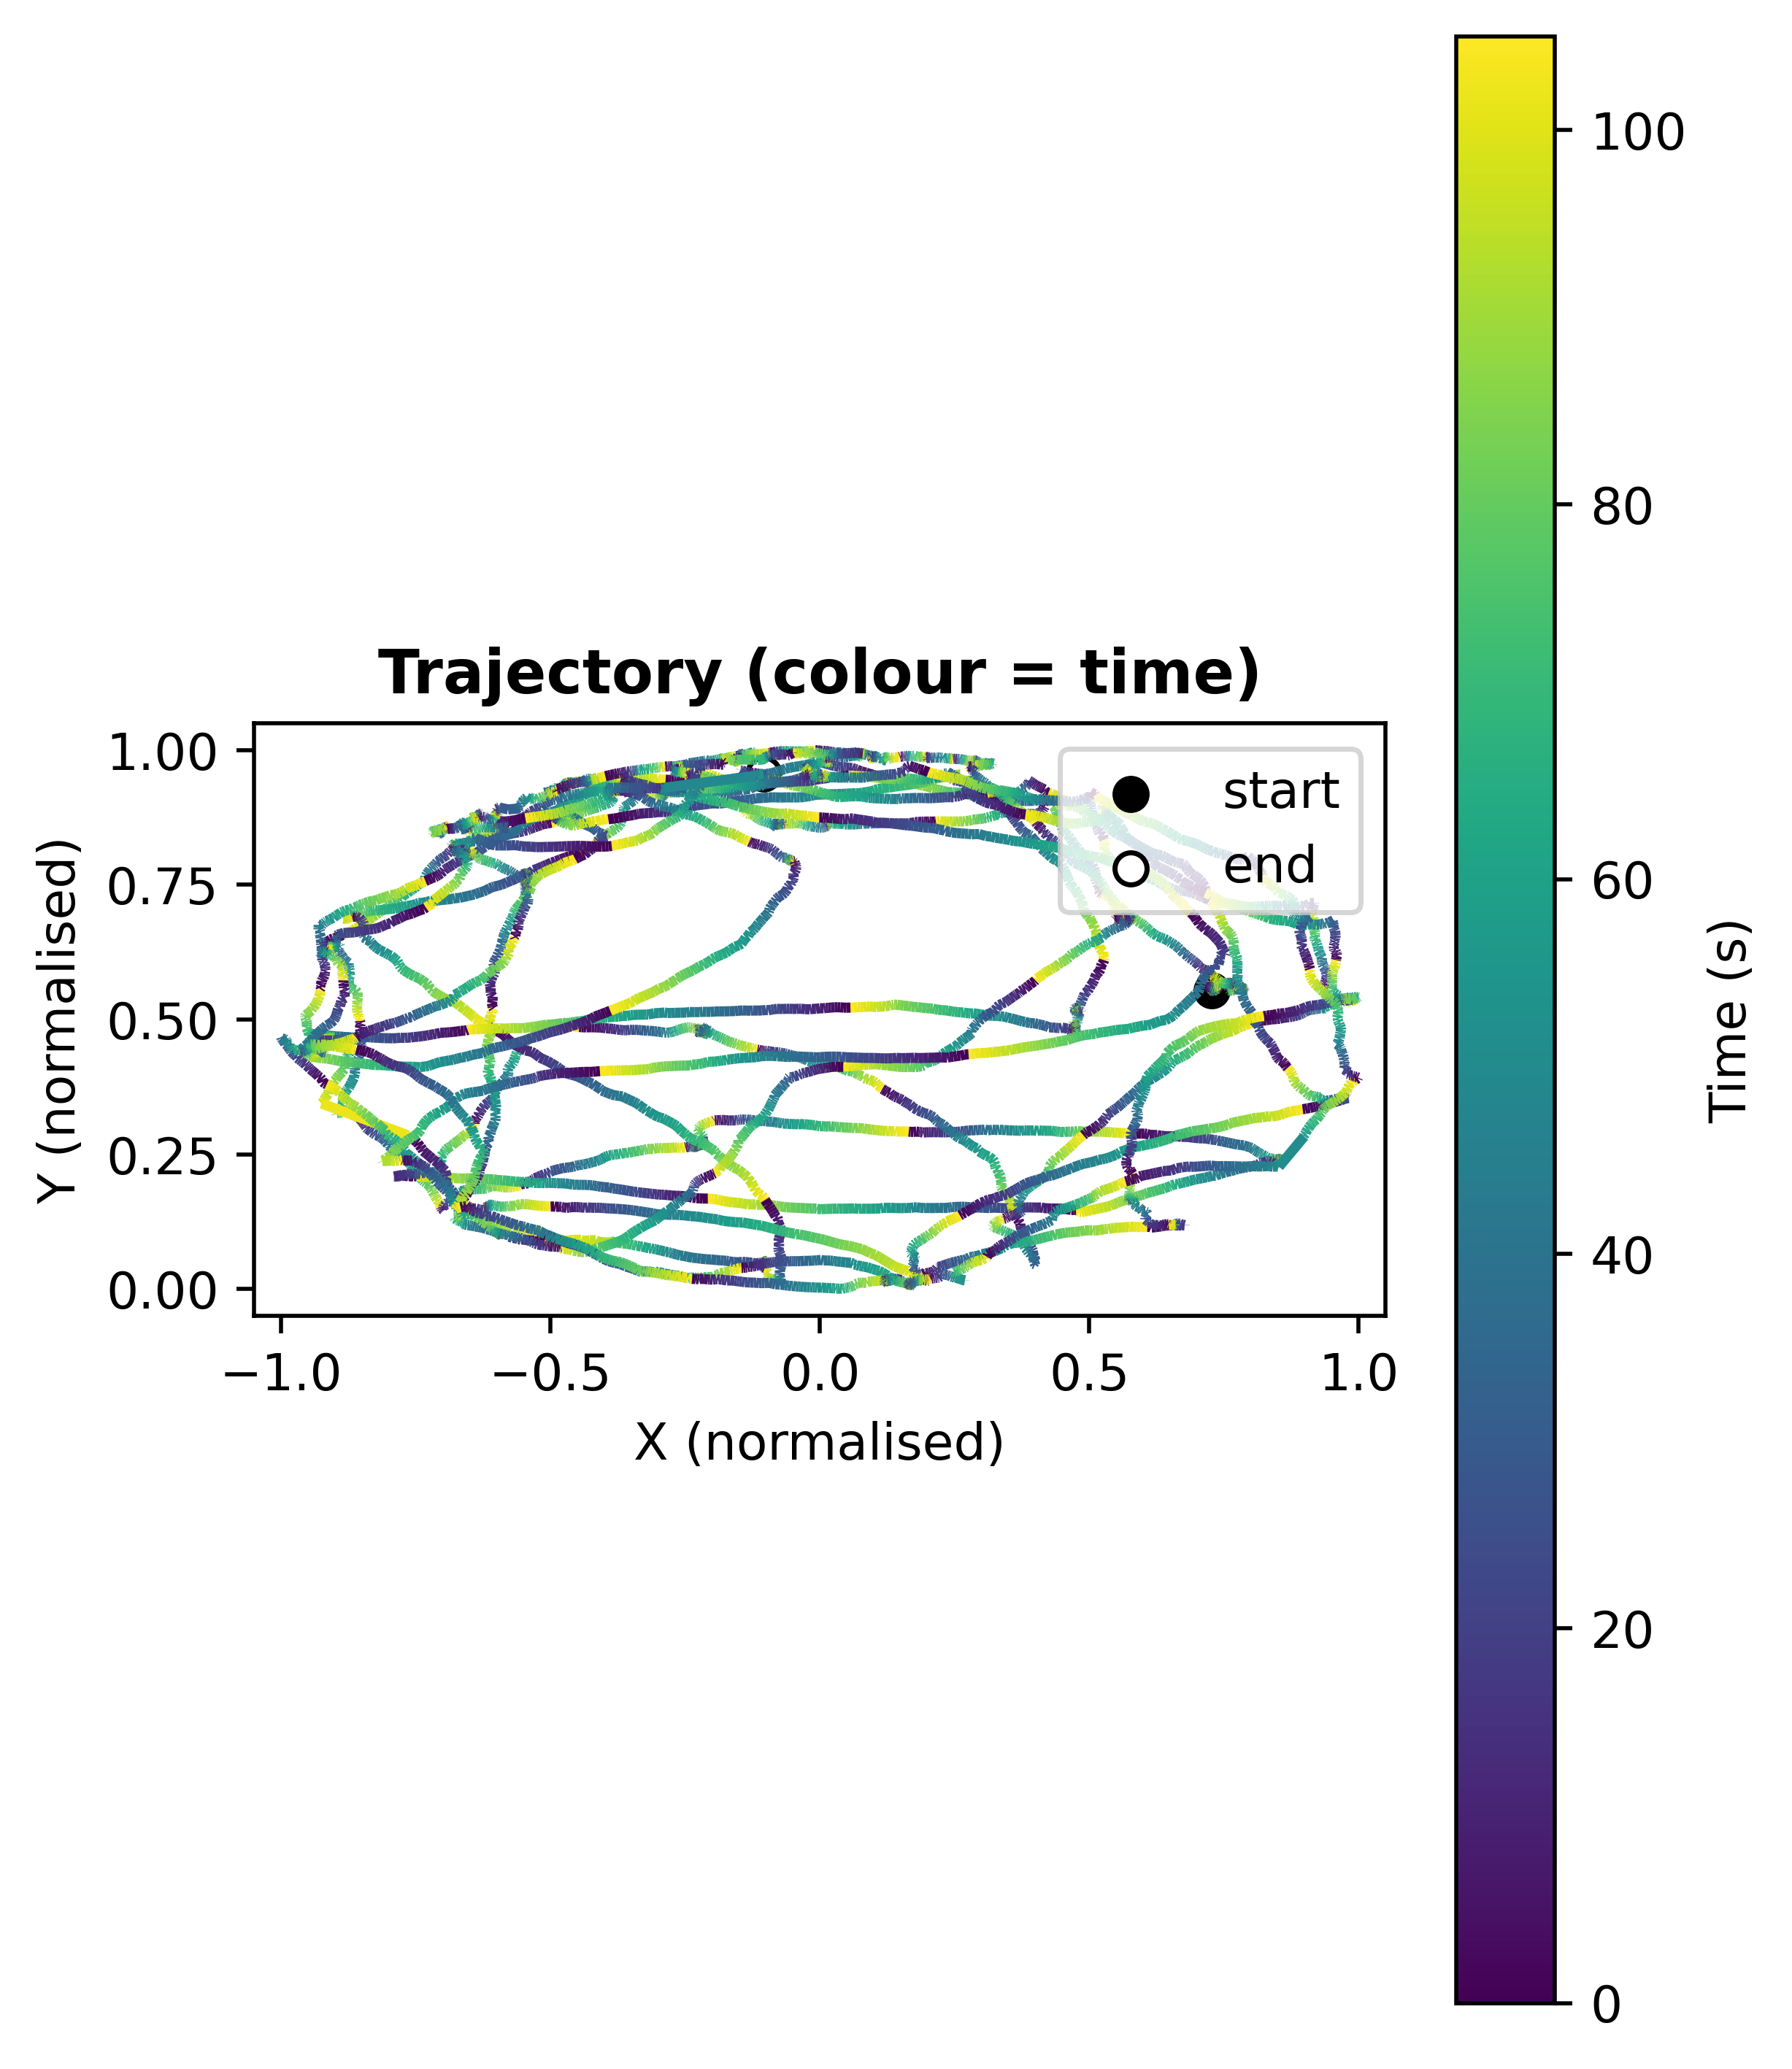

In [82]:
plot_trajectory_time_heatmap(control, scatter_tail=True)

In [86]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_distance_spline(
        fish_obj,
        title        = "Cumulative distance (spline)",
        color        = "tomato",
        y_label      = "Distance (arena units)",
        figsize      = (8,5)):

    x = fish_obj.spline_x.iloc[:, 0].values              # length = trial_length
    # if you stored spline_y, use it; else fall back to raw y resampled on-the-fly
    try:
        y = fish_obj.spline_y.iloc[:, 0].values
    except AttributeError:
        # quick 1-D spline of Y so we keep matching length
        from scipy.interpolate import CubicSpline
        raw_y = fish_obj.y[0]
        ts    = np.linspace(0, fish_obj.trial_length, len(raw_y))
        y     = CubicSpline(ts, raw_y)(fish_obj.time)

    step = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    cum  = np.concatenate([[0], np.cumsum(step)])

    plt.figure(figsize=figsize)
    plt.plot(fish_obj.time, cum, color=color, lw=3)
    plt.xlabel("Time (s)")
    plt.ylabel(y_label)
    plt.title(title, fontweight="bold")
    plt.tight_layout()
    plt.show()


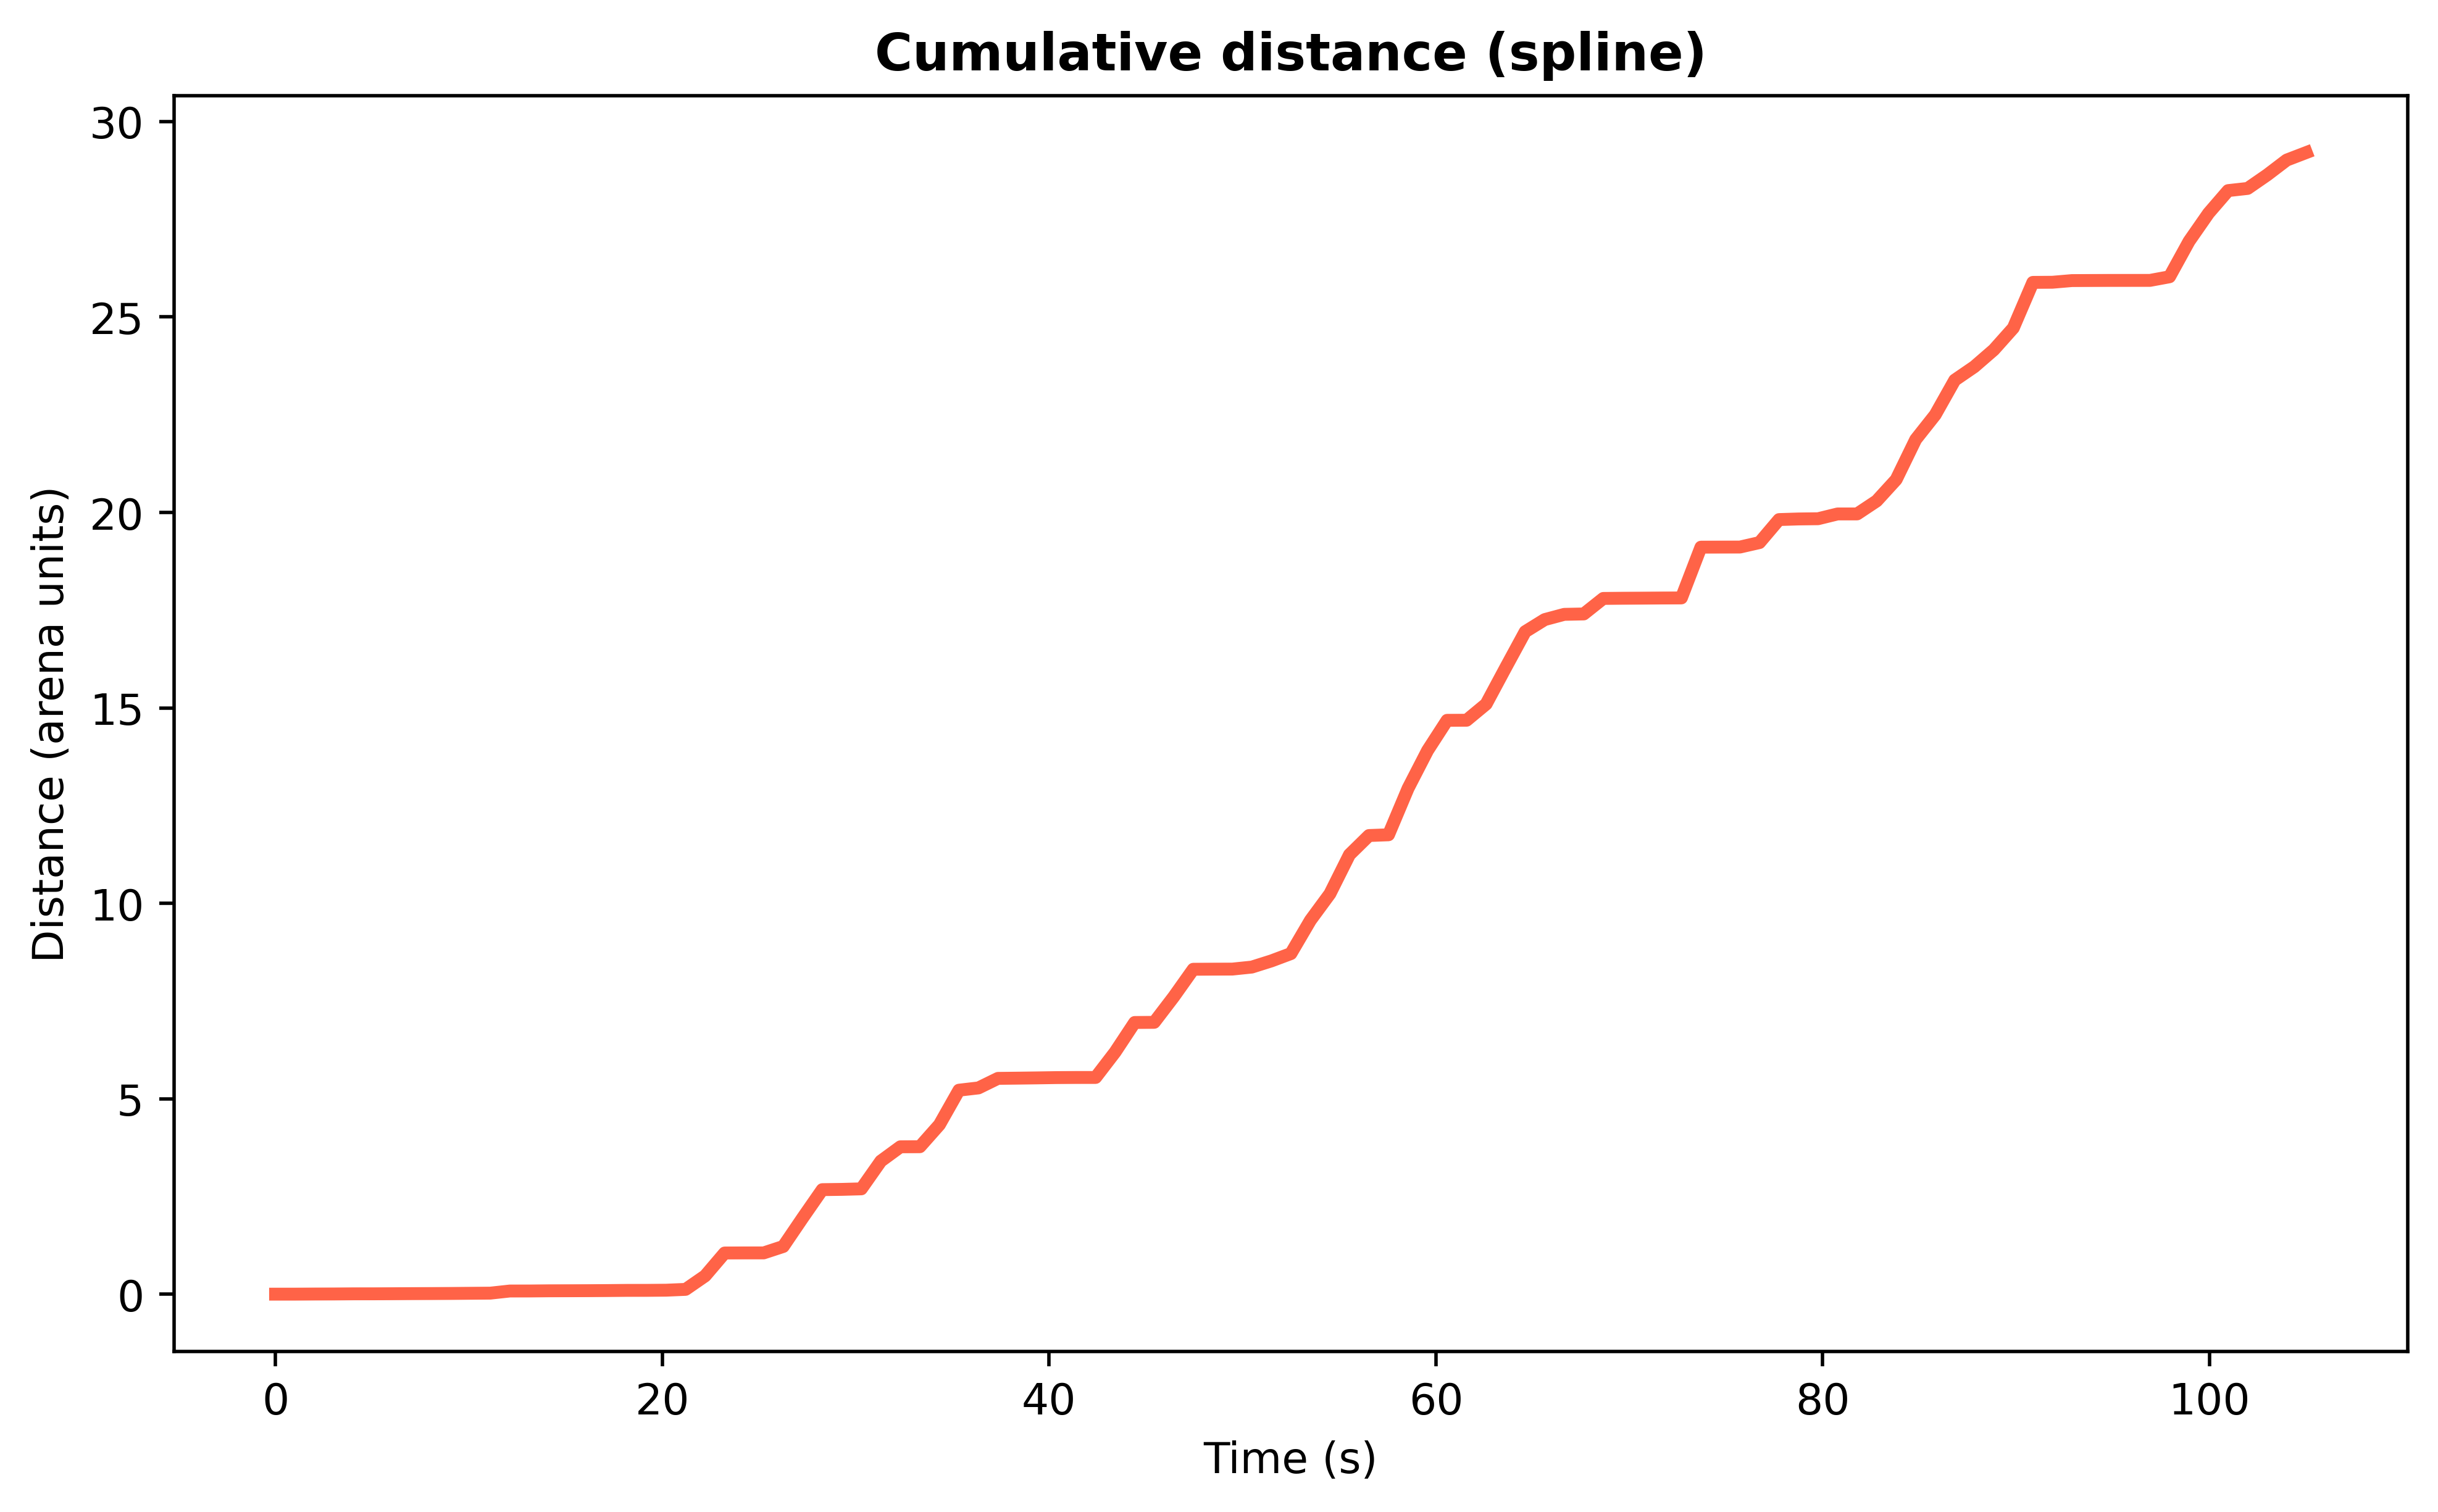

In [87]:
plot_cumulative_distance_spline(control)

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

def speed_spectrogram(fish_obj,
                      preset      = "A",          # "A", "B" or "C" (see below)
                      raw_speed   = None,         # optional 100 Hz series
                      cmap        = "magma"):
    """
    Plot a spectrogram of speed.

    Presets
    -------
    "A" : 1 Hz spline, 32 s window        – slow wander / pause rhythms
    "B" : 10 Hz (interp), 25.6 s window   – 0.1-10 s bursts and pauses
    "C" : 100 Hz (needs raw_speed), 5 s   – sub-second detail

    Parameters
    ----------
    fish_obj   : animal_behavior_stats
                 Must contain fish_obj.spline_sp (1 Hz, length 105).
    preset     : str  "A", "B", or "C"
    raw_speed  : ndarray | None
                 If you recorded 100 Hz speed, pass it here for preset "C".
                 Otherwise the function will up-sample the spline (OK but lower fidelity).
    cmap       : str  Matplotlib colormap name
    """

    # ------------------------------------------------------ preset table
    presets = {
        "A": dict(fs=1,   nperseg=32,  noverlap=16,
                  title="Spectrogram – 1 Hz (32 s window)"),
        "B": dict(fs=10,  nperseg=256, noverlap=128,
                  title="Spectrogram – 10 Hz (25 s window)"),
        "C": dict(fs=100, nperseg=512, noverlap=256,
                  title="Spectrogram – 100 Hz (5 s window)"),
    }
    if preset not in presets:
        raise ValueError("preset must be 'A', 'B' or 'C'")

    p = presets[preset]

    # ------------------------------------------------------ get speed series
    spline_speed = fish_obj.spline_sp.iloc[:, 0].values   # 1 Hz, length 105 s

    if p["fs"] == 1:
        speed = spline_speed                                   # 1 Hz ready
    elif p["fs"] == 10:
        # up-sample the spline to 10 Hz (linear interpolation)
        t_old = fish_obj.time                                  # 0…105 (step 1 s)
        t_new = np.arange(0, fish_obj.trial_length, 1/p["fs"]) # 0…105 (step 0.1 s)
        speed = np.interp(t_new, t_old, spline_speed)
    elif p["fs"] == 100:
        if raw_speed is not None and len(raw_speed) == 10500:
            speed = raw_speed                                  # use true 100 Hz
        else:
            # fall back to up-sampling spline (lower fidelity)
            t_old = fish_obj.time
            t_new = np.arange(0, fish_obj.trial_length, 1/p["fs"])
            speed = np.interp(t_new, t_old, spline_speed)
            print("⚠️  Using up-sampled spline for 100 Hz; "
                  "pass raw_speed=… for best resolution.")

    # ------------------------------------------------------ spectrogram
    f, t, Sxx = spectrogram(speed,
                            fs       = p["fs"],
                            nperseg  = p["nperseg"],
                            noverlap = p["noverlap"],
                            detrend  = False,
                            scaling  = "density")

    Sxx_dB = 10 * np.log10(Sxx + 1e-12)

    # ------------------------------------------------------ plot
    plt.figure(figsize=(10, 4))
    mesh = plt.pcolormesh(t, f, Sxx_dB, shading="auto", cmap=cmap)
    plt.colorbar(mesh, label="Power (dB)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim(0, p["fs"]/2)              # Nyquist
    plt.title(p["title"], fontweight="bold")


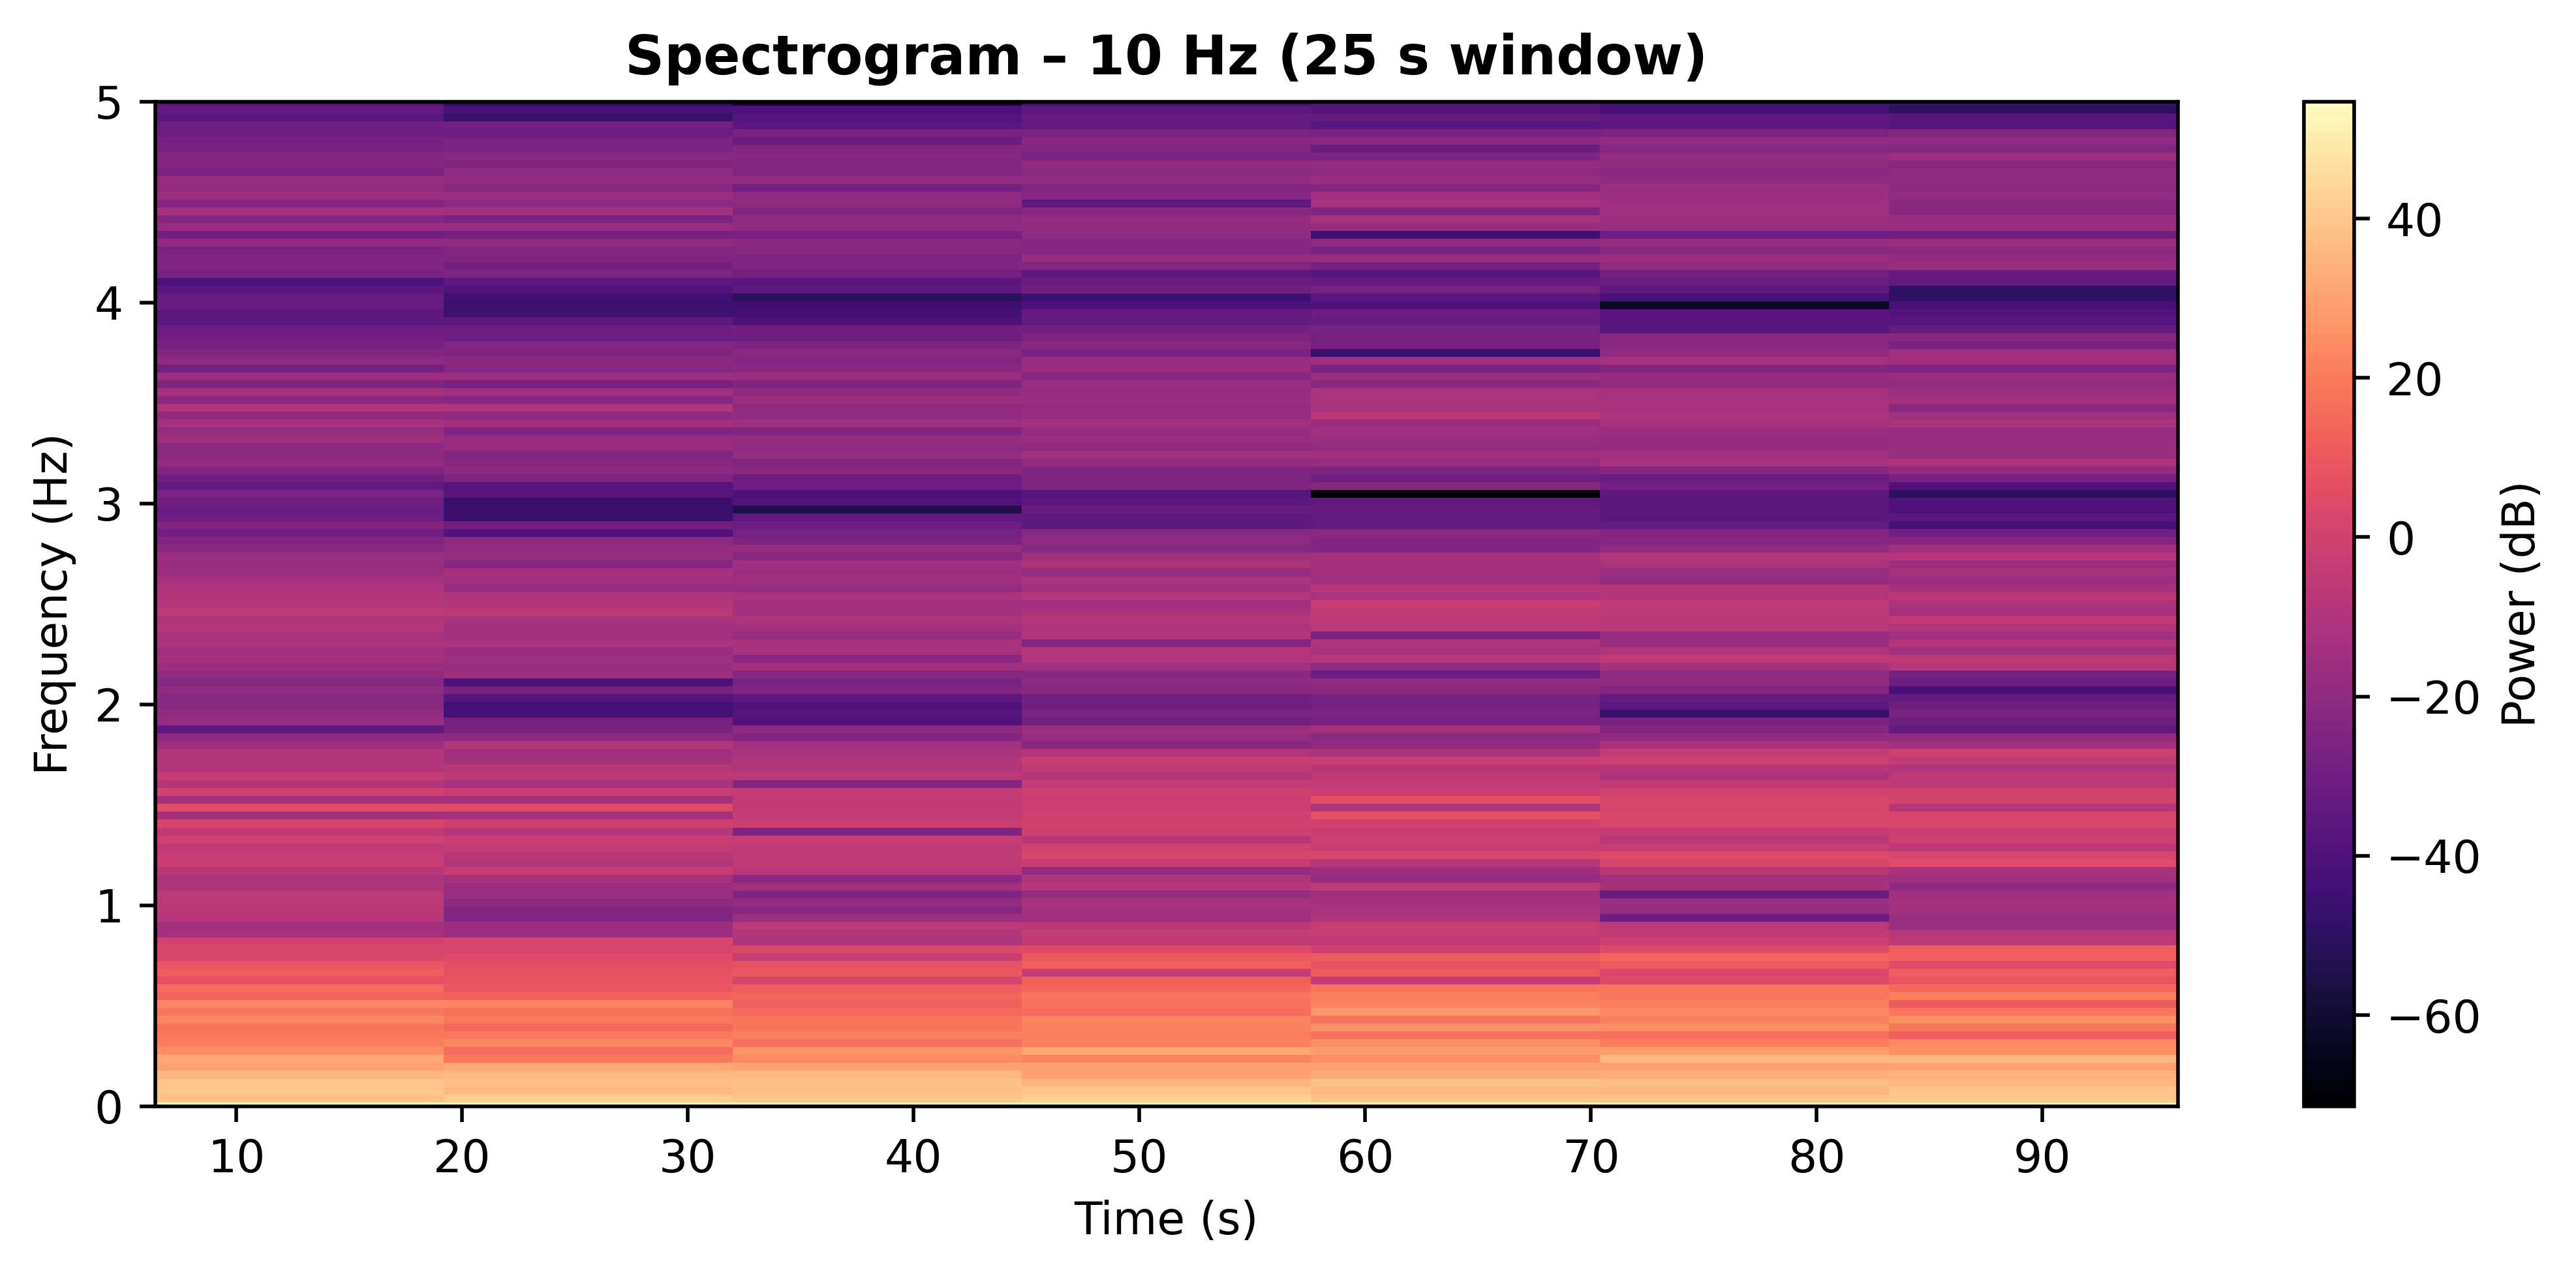

In [93]:
speed_spectrogram(control, preset="B")